In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras import models, layers

In [2]:
# Load datasets
df_purchase = pd.read_csv("user_demographics.csv")
df_user = pd.read_csv("User_product_purchase_details_p2.csv")

In [ ]:
# Data preprocessing
df = pd.merge(df_purchase, df_user, on="User_ID", how="left")
df["High_Value_Purchase"] = (df["Purchase"] >= 10000).astype(int)
df = df.drop(["Product_ID"], axis=1)
df = df.fillna(0)
df = pd.get_dummies(df, columns=["Gender","Age","City_Category","Stay_In_Current_City_Years"], drop_first=True)

X = df.drop(["High_Value_Purchase","Purchase"], axis=1)
y = df["High_Value_Purchase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Neural Network Model
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

log = LogisticRegression(max_iter=2000)
log.fit(X_train_scaled, y_train)
pred_lr = log.predict(X_test_scaled)

print("LR Accuracy:", accuracy_score(y_test, pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_lr))

# Precision, Recall, F1
print("Precision:", precision_score(y_test, pred_lr))
print("Recall:", recall_score(y_test, pred_lr))
print("F1 Score:", f1_score(y_test, pred_lr))

LR Accuracy: 0.7673750613558274
Confusion Matrix:
 [[64943  7163]
 [18429 19479]]
Precision: 0.7311388033931386
Recall: 0.513849319404875
F1 Score: 0.6035321456235476


In [12]:
# MLP Model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["precision"])
history = model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=1)

loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print("MLP precision:", acc)

Epoch 1/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.3802 - precision: 0.7747 - val_loss: 0.3086 - val_precision: 0.7948
Epoch 2/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.2979 - precision: 0.7878 - val_loss: 0.2901 - val_precision: 0.7900
Epoch 3/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.2869 - precision: 0.7883 - val_loss: 0.2908 - val_precision: 0.8015
Epoch 4/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 11s 992us/step - loss: 0.2808 - precision: 0.7882 - val_loss: 0.2800 - val_precision: 0.7925
Epoch 5/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.2713 - precision: 0.7898 - val_loss: 0.2711 - val_precision: 0.7899
Epoch 6/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 11s 957us/step - loss: 0.2655 - precision: 0.7905 - val_loss: 0.2650 - val_precision: 0.7905
Epoch 7/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 10s 928us/step - loss: 0.2629 - precision: 0.7914 - val_loss: 0.2676 - val_precision: 0.8069
Epoch 8/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 11s 9

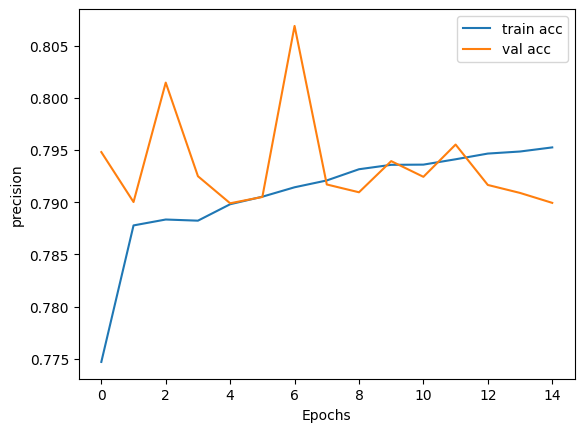

In [14]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(history.history['precision'], label='train acc')
plt.plot(history.history['val_precision'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()

In [ ]:
#Which feature appear most influential?
# Compare accuracies
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred_lr))
print("MLP Accuracy:", acc)

# Quick interpretation
if acc > accuracy_score(y_test, pred_lr):
    print("The MLP performed better than Logistic Regression.")
else:
    print("Logistic Regression performed better or similar to MLP.")

Logistic Regression Accuracy: 0.7673750613558274
MLP Accuracy: 0.899621844291687
The MLP performed better than Logistic Regression.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names and coefficients
feature_names = X.columns
coefficients = log.coef_[0]

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Absolute_Importance": np.abs(coefficients)
}).sort_values(by="Absolute_Importance", ascending=False)

# Show top 10 features
importance_df.head(10)

,Feature,Coefficient,Absolute_Importance
3,Product_Category_1,-0.850217,0.850217
5,Product_Category_3,0.426587,0.426587
6,Gender_M,0.109457,0.109457
14,City_Category_C,0.105600,0.105600
9,Age_36-45,0.077017,0.077017
8,Age_26-35,0.072667,0.072667
11,Age_51-55,0.065048,0.065048
10,Age_46-50,0.045219,0.045219
7,Age_18-25,0.035726,0.035726
13,City_Category_B,0.031580,0.031580


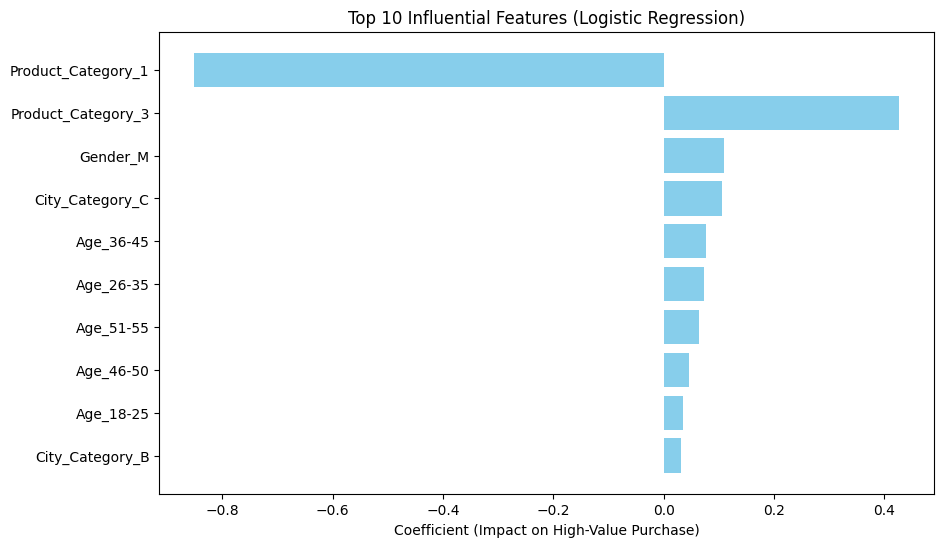

In [9]:
top_features = importance_df.head(10)
plt.figure(figsize=(10,6))
plt.barh(top_features["Feature"], top_features["Coefficient"], color="skyblue")
plt.xlabel("Coefficient (Impact on High-Value Purchase)")
plt.title("Top 10 Influential Features (Logistic Regression)")
plt.gca().invert_yaxis()
plt.show()